In [2]:
import sys
# This on is a path correcting code, which is used to find the path of qusim.
sys.path.append('../../../..')
import qusim.DataPlot.plot_lib as pl
import qusim.Instruments.tools as tools
import qusim.Instruments.stochastic_gen as sg
import qusim.System.arb_qubit_system as aqs
import qusim.Instruments.angle as  ang

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle

from qutip import*

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

from qusim.Instruments.qsave import *
path = '../../../../Data/erasure_qubit/'
qsv = qsave(path)

# Ideal gate test

## Single qubit $\sigma_x$ eigenstates

### Logic Rz

In [2]:
s0 = basis(2,0)
s1 = basis(2,1)
sp = s0 + s1
sm = s0 - s1
spm = tensor(sp, sm)
smp = tensor(sm, sp)
spp = tensor(sp, sp)
smm = tensor(sm, sm)

theta = np.pi/3
Rx = Qobj([[np.cos(theta/2) ,-1j*np.sin(theta/2)], [-1j * np.sin(theta/2), np.cos(theta/2)]], dims=[[2],[2]])
Rx = tensor(Rx, qeye(2))
Rx * spm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.8660254-0.5j]
 [-0.8660254+0.5j]
 [ 0.8660254-0.5j]
 [-0.8660254+0.5j]]

### Logic Rx pi/2

$$R_{zz}|+-\rangle = (|+-\rangle - i|-+\rangle)/\sqrt{2}$$

$$R_{zz}|-+\rangle = (|-+\rangle - i|+-\rangle)/\sqrt{2}$$

In [4]:
phi = np.pi/2
R_zz = Qobj(
    np.array([[np.exp(-1j*phi/2), 0, 0, 0],
              [0, np.exp(1j*phi/2), 0, 0],
              [0, 0, np.exp(1j*phi/2), 0],
              [0, 0, 0, np.exp(-1j*phi/2)]]), dims=[[2,2], [2,2]]
)

R_zz * spm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [-0.70710678-0.70710678j]
 [ 0.70710678+0.70710678j]
 [-0.70710678+0.70710678j]]

In [5]:
R_zz * smp

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [ 0.70710678+0.70710678j]
 [-0.70710678-0.70710678j]
 [-0.70710678+0.70710678j]]

In [6]:
1/np.sqrt(2) * (spm - 1j * smp)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [-0.70710678-0.70710678j]
 [ 0.70710678+0.70710678j]
 [-0.70710678+0.70710678j]]

In [7]:
1/np.sqrt(2) * (smp - 1j * spm)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [ 0.70710678+0.70710678j]
 [-0.70710678-0.70710678j]
 [-0.70710678+0.70710678j]]

In [25]:
J23 = 1
tg = 1/8
H_xyz = J23 * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()) + tensor(sigmaz(), sigmaz()))
U_xyz = (-1j*2*np.pi*H_xyz*tg).expm()
U_xyz = U_xyz/U_xyz.data[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

This also works as $R_x(\pi/2)$. In ST0 language, basically a $\pi/2$ rotation along $J$ axis: $|\uparrow \downarrow\rangle \leftrightarrow |\downarrow \uparrow\rangle$.

In [28]:
U_xyz*spm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [ 0.70710678-0.70710678j]
 [-0.70710678+0.70710678j]
 [-0.70710678+0.70710678j]]

In [30]:
U_xyz*smp

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678-0.70710678j]
 [-0.70710678+0.70710678j]
 [ 0.70710678-0.70710678j]
 [-0.70710678+0.70710678j]]

### Logic CZ

In [14]:
phi = np.pi
R_xx =  Qobj(
    np.array([[np.cos(phi/2), 0, 0, -1j * np.sin(phi/2)],
              [0, np.cos(phi/2), -1j * np.sin(phi/2), 0],
              [0, -1j * np.sin(phi/2), np.cos(phi/2), 0],
              [-1j * np.sin(phi/2), 0, 0, np.cos(phi/2)]]), dims=[[2,2], [2,2]]
)
R_x_pi = Qobj(
    np.array([
        [np.cos(-phi/2), -1j*np.sin(-phi/2)],
        [-1j*np.sin(-phi/2), np.cos(-phi/2)]
    ]), dims=[[2], [2]]
)


R_yy =  Qobj(
    np.array([[np.cos(phi/2), 0, 0, 1j * np.sin(phi/2)],
              [0, np.cos(phi/2), -1j * np.sin(phi/2), 0],
              [0, -1j * np.sin(phi/2), np.cos(phi/2), 0],
              [1j * np.sin(phi/2), 0, 0, np.cos(phi/2)]]), dims=[[2,2], [2,2]]
)
R_y_pi = Qobj(
    np.array([
        [np.cos(-phi/2), -np.sin(-phi/2)],
        [np.sin(-phi/2), np.cos(-phi/2)]
    ]), dims=[[2], [2]]
)

R_z_pi = Qobj(
    np.array([
        [np.exp(-1j*phi/2), 0],
        [0, np.exp(1j*phi/2)]
    ]), dims=[[2], [2]]
)

CZ = -1*ket2dm(smm) + ket2dm(spp) + ket2dm(smp) + ket2dm(spm)
CZ = CZ/4

R_z_pi = tensor(qeye(2), R_z_pi)
R_x_pi = tensor(qeye(2), R_x_pi)
R_y_pi = tensor(R_y_pi, R_y_pi)

ss= spm
ss.dag() * R_x_pi * CZ* ss * (-1j)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-4.]]

In [22]:
s0 = basis(2,0)
s1 = basis(2,1)
sp = s0 + s1
sm = s0 - s1
spm = tensor(sp, sm)
smp = tensor(sm, sp)
spp = tensor(sp, sp)
smm = tensor(sm, sm)

spmpm = tensor(spm, spm) # 00
spmmp = tensor(spm, smp) # 01
smppm = tensor(smp, spm) # 10
smpmp = tensor(smp, smp) # 11

spmmm = tensor(spm, smm)
smmmm = tensor(smm, smm)
smmpm = tensor(smm, spm)

spmpp = tensor(spm, spp)
spppp = tensor(spp, spp)
spppm = tensor(spp, spm)

smpmm = tensor(smp, smm)
smmmp = tensor(smm, smp)

smppp = tensor(smp, spp)
sppmp = tensor(spp, smp)

sppmm = tensor(spp, smm)
smmpp = tensor(smm, spp)

one_list = [spmpm, smppm, smpmp, smmpm, spmpp, spppp, spppm, smpmm, smppp, sppmp, sppmm, smmpp]
negative_one_list = [spmmp, spmmm, smmmm, smmmp]

# CZ = 1/16 * ()
CZ = 0
for bass in one_list:
    CZ += ket2dm(bass)
for bass in negative_one_list:
    CZ += -1* ket2dm(bass)
CZ *= 1/16

phi = np.pi
R_x_pi = Qobj(
    np.array([
        [np.cos(-phi/2), -1j*np.sin(-phi/2)],
        [-1j*np.sin(-phi/2), np.cos(-phi/2)]
    ]), dims=[[2], [2]]
)
R_x_pi = tensor(tensor(qeye(2), qeye(2)), tensor(R_x_pi, qeye(2)))

ss = smpmp
ss.dag() * R_x_pi * CZ *ss*(-1j)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-16.]]

### Measurement

In [12]:
psi = tensor(sp,s0)+tensor(sm,s1)
psi_dm = ket2dm(psi)/4
m_op = tensor(qeye(2), ket2dm(s1))
m_op*psi_dm*m_op*2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5  0.  -0.5]
 [ 0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5]]

In [13]:
ket2dm(sm)/2

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5 -0.5]
 [-0.5  0.5]]

### +- CZ in 01 basis

In [46]:
s0 = basis(2,0)
s1 = basis(2,1)
sp = s0 + s1
sm = s0 - s1
spm = tensor(sp, sm)
smp = tensor(sm, sp)
spp = tensor(sp, sp)
smm = tensor(sm, sm)

phi = np.pi/2

R_y_half_pi = Qobj(
    np.array([
        [np.cos(-phi/2), -np.sin(-phi/2)],
        [np.sin(-phi/2), np.cos(-phi/2)]
    ]), dims=[[2], [2]]
)

R_x_half_pi = Qobj(
    np.array([
        [np.cos(-phi/2), -1j*np.sin(-phi/2)],
        [-1j*np.sin(-phi/2), np.cos(-phi/2)]
    ]), dims=[[2], [2]]
) 

CZ_in01 = -1* ket2dm(smm) +  ket2dm(spp) + ket2dm(spm) + ket2dm(smp)
CZ_in01/=4

In [56]:
UR= tensor(R_y_half_pi,R_y_half_pi)
UR*CZ_in01*UR.dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [19]:
J23 = 1
tg = 1/8
H_xyz = J23 * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()) + tensor(sigmaz(), sigmaz()))
U_xyz = (-1j*2*np.pi*H_xyz*tg).expm()
U_xyz = U_xyz/U_xyz.data[0,0]
U_xyz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

# Real-time dynamics

## Define system

In [ ]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }]
    ,
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = { # 04/12/24 change residual coupling
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j 
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb.get_eigenstates_energy((1,0,0,0))

"""subspace for CZ"""
state_0101, E_0101, index_0101= _system_arb.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb.get_eigenstates_energy((1,0,1,0))

"""leakage for CZ"""
state_0011, E_0011, index_0011= _system_arb.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

state_S = (state_ud+state_du)/np.sqrt(2)
state_T0 = (state_ud-state_du)/np.sqrt(2)

"""Define logic qubit subspace"""
state_L0 = state_uddu
state_L1 = state_duud

"""Define leakage state"""
state_mm = state_dudu
state_pp = state_udud

"""State in ST0"""

state_SS = tensor(state_S,state_S)
state_ST0 = tensor(state_S,state_T0)
state_T0S = tensor(state_T0,state_S)
state_T0T0 = tensor(state_T0,state_T0)

_system_arb.H

## Physical qubit gate calibration

### Single qubit $R_x(\pi/2)$

### Virtual Z gate

## Logic qubit case, Two Data qubit

$$
H_{eff} = \omega_1 \sigma_z^1 + \omega_2 \sigma_z^2 + \omega_a \sigma_Z^a + \chi \sigma_z^1 \sigma_z^2
$$

### logic Rz gate

### Logic Rx(pi/2) gate

In [268]:
tg = 100;
amp1 = 12.8/(8*tg)-1e-3 
amp2 = 12.8/(8*tg)-1e-3
amp3 = 3.8/(8*tg)-1e-3
simulation_option = {
    "simulation_time": tg, # ns
    "simulation_step": 10000,
    "initial_state": [state_L0,state_L1] # Do multiple simulation
}
pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': tg, # unit in ns
        't_plateau':0 , # unit in ns
        'freq': freq_list[0][1]-freq_list[1][1], # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': amp1, # XY: Rabi freq; Z: biased frequency
        'q_index': [0,1]
    },
    {
        'pulse_index': 1,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': tg, # unit in ns
        't_plateau':0 , # unit in ns
        'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
        'q_index': [2,3]
    },
    {
        'pulse_index': 2,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': tg, # unit in ns
        't_plateau':0 , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': amp3, # XY: Rabi freq; Z: biased frequency
        'q_index': [1,2]
    }
]
%matplotlib inline
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

0

In [133]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
# propa_list = _system_arb.system_dynamics_propagator(simulation_option, pulse_sequence)

#### Data display

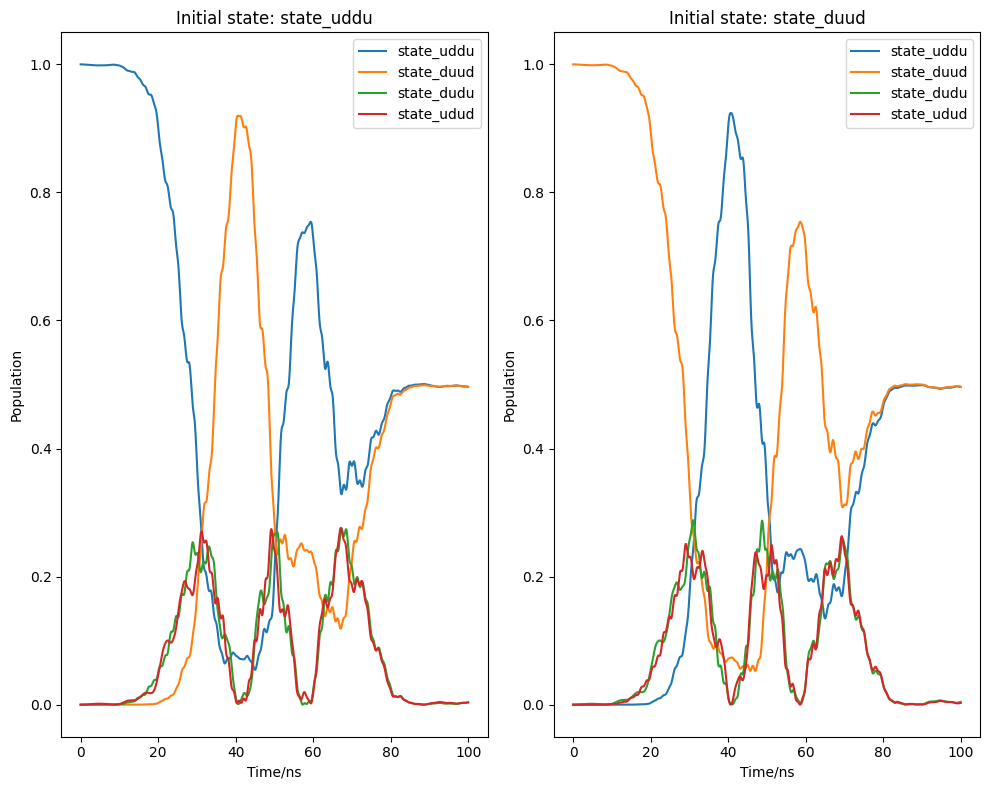

0

In [135]:
interested_state = [
                    [state_L0,state_L1, state_dudu, state_udud],
                    [state_L0,state_L1, state_dudu, state_udud]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

### CZ for parity check


In [133]:
cp_matix = pickle.load(open('../../../../Data/cp_matrix.pkl', 'rb')) 
qp_matix = pickle.load(open('../../../../Data/qp_matrix.pkl', 'rb')) 

c_phase_gate = Qobj(cp_matix,
              dims = [[2,2], [2,2]])

q_phase_gate = Qobj(qp_matix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
phi01 = np.angle(c_phase_gate.data[1,1])
phi23 = np.angle(c_phase_gate.data[2,2])

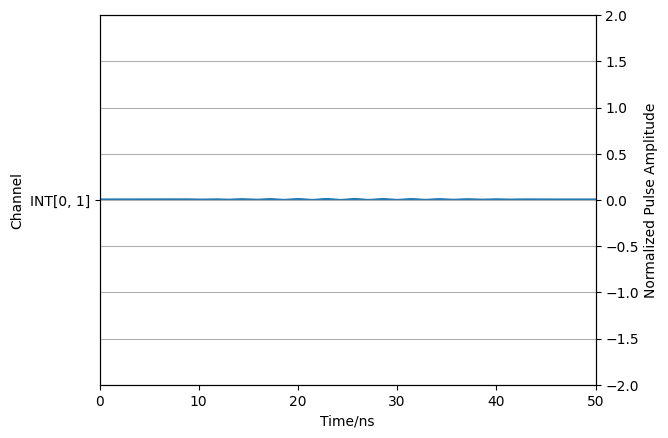

0

In [242]:
tcz = 35; J23_bias = 5.152e-3
tg = 50
amp1 = 1.01/(2*tg) # pi
amp2 = 0.504/(2*tg) # pi/2
phase_scan = np.pi/2 *0

simulation_option = {
    "simulation_time": tg, # ns
    "simulation_step": 10000,
    "initial_state": [state_udud]#[state_SS, state_ST0,state_T0S,state_T0T0]#[state_L0,state_L1] # Do multiple simulation
}
pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': tg, # unit in ns
        't_plateau':0 , # unit in ns
        'freq': freq_list[0][1]-freq_list[1][1], # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
        'offset': amp2,
        'q_index': [0,1],
    },
]
%matplotlib inline
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [243]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
# propa_list = _system_arb.system_dynamics_propagator(simulation_option, pulse_sequence)

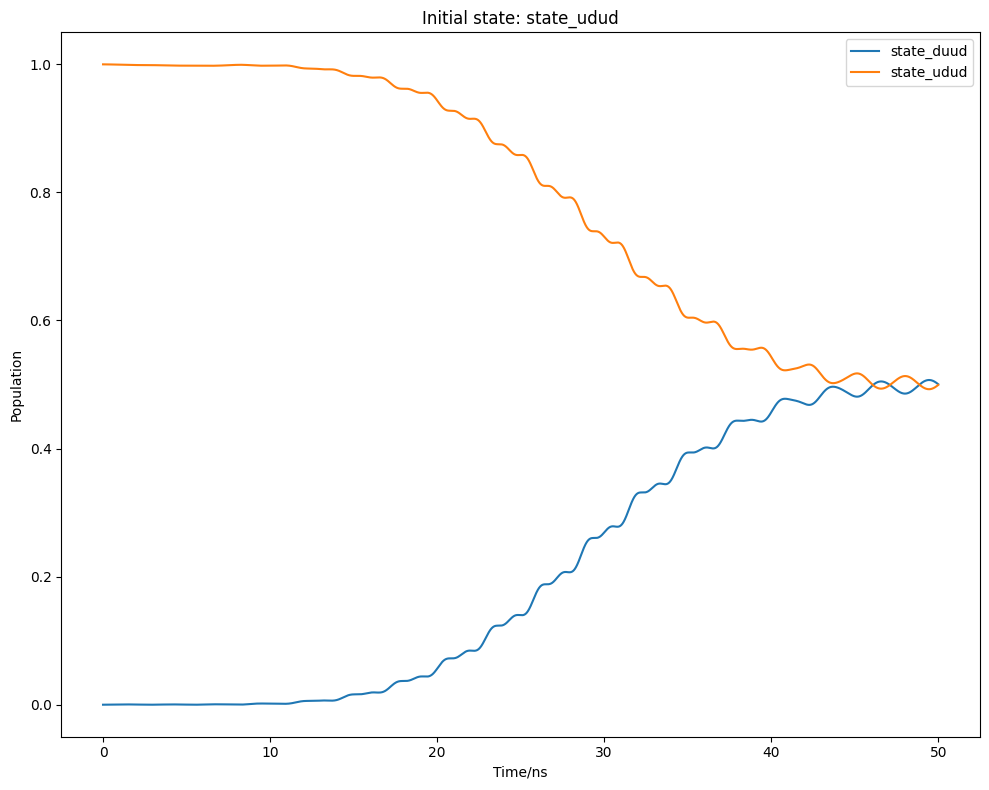

0

In [244]:
interested_state = [
                    [state_duud, state_udud],
                    # [state_L0,state_L1, state_dudu, state_udud]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

#### Scan CZ angle

In [308]:
tcz = 35; 
J23_bias = 2e-3#5.152e-3
tg = 50
amp1 = 1.01/(2*tg) # pi
amp2 = 0.504/(2*tg) # pi/2
phase_scan = np.pi/2 *0
q2_signal_lst = []
phase_scan_bound = [-np.pi,np.pi,100]
phase_scan_rng = np.linspace(*phase_scan_bound)
for phase_scan in tqdm(phase_scan_rng):

    simulation_option = {
        "simulation_time": tg*2+tcz, # ns
        "simulation_step": 10000,
        "initial_state": [state_udud]#[state_SS, state_ST0,state_T0S,state_T0T0]#[state_L0,state_L1] # Do multiple simulation
    }
    pulse_sequence = [
        {
            'pulse_index': 1,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': tg, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': freq_list[0][1]-freq_list[1][1], # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': amp1, # XY: Rabi freq; Z: biased frequency
            'offset': amp1,
            'q_index': [0,1]
        },
        {
            'pulse_index': 2,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay':0, # unit in ns
            't_width': tg, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
            'offset': amp2,
            'q_index': [2,3]
        },
        {
            'pulse_index': 3,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': tg, # unit in ns
            't_width': tcz, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': J23_bias, # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2]
        },
        {
            'pulse_index': 3,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay':tcz+tg, # unit in ns
            't_width': tg, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
            'phase': phase_scan, # unit in rad; Z pulse does not use it
            'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
            'offset': amp2,
            'q_index': [2,3]
        },
    ]
    result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
    q2_signal = np.abs((state_duud.dag()*result_list[0].states[-1]).data[0,0])**2 + np.abs((state_udud.dag()*result_list[0].states[-1]).data[0,0])**2
    q2_signal_lst.append(q2_signal)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


In [309]:
q2_signal_lst_withoutX = []
# phase_scan_rng = np.linspace(-np.pi,np.pi,100)
for phase_scan in tqdm(phase_scan_rng):

    simulation_option = {
        "simulation_time": tg*2+tcz, # ns
        "simulation_step": 10000,
        "initial_state": [state_udud]#[state_SS, state_ST0,state_T0S,state_T0T0]#[state_L0,state_L1] # Do multiple simulation
    }
    pulse_sequence = [
        {
            'pulse_index': 2,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay':0, # unit in ns
            't_width': tg, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
            'offset': amp2,
            'q_index': [2,3]
        },
        {
            'pulse_index': 3,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': tg, # unit in ns
            't_width': tcz, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': J23_bias, # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2]
        },
        {
            'pulse_index': 3,
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay':tcz+tg, # unit in ns
            't_width': tg, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
            'phase': phase_scan, # unit in rad; Z pulse does not use it
            'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
            'offset': amp2,
            'q_index': [2,3]
        },
    ]
    result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
    q2_signal = np.abs((state_duud.dag()*result_list[0].states[-1]).data[0,0])**2 + np.abs((state_udud.dag()*result_list[0].states[-1]).data[0,0])**2
    q2_signal_lst_withoutX.append(q2_signal)

100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


In [310]:
data = {
    'scan': {'scan_name': 'phase_scan_rng' , 'scan_rng': phase_scan_bound, 'scan_vari': phase_scan_rng, } ,
    'config': {'option': simulation_option, 'tcz': tcz, 'tg': tg, 'cz_amp': J23_bias,'pi_amp': amp1, 'pi/2_amp': amp2},
    'data': {'data': [q2_signal_lst, q2_signal_lst_withoutX], 'label': ['q2_signal_lst', 'q2_signal_lst_withoutX']}
}
qsv.save('cphase_scan_phi',data=data)

Save as file cphase_scan_phi_5.pkl


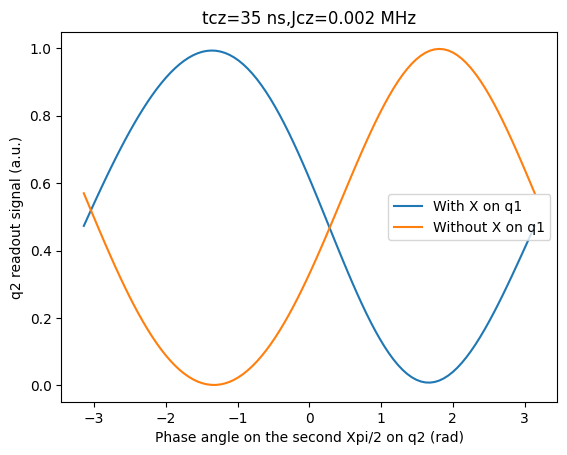

3.173325912716963

In [311]:
from scipy.signal import find_peaks
peaks_with_X, _ = find_peaks(q2_signal_lst)
peaks_without_X, _ = find_peaks(q2_signal_lst_withoutX)
first_peak_with_X = phase_scan_rng[peaks_with_X][0]
first_peak_without_X = phase_scan_rng[peaks_without_X][0]

horizontal_shift = np.abs(first_peak_with_X - first_peak_without_X)

%matplotlib inline
plt.figure()
plt.plot(phase_scan_rng, q2_signal_lst, label="With X on q1")
plt.plot(phase_scan_rng, q2_signal_lst_withoutX, label="Without X on q1")
plt.xlabel("Phase angle on the second Xpi/2 on q2 (rad)")
plt.ylabel(r"q2 readout signal (a.u.)")
plt.legend()
plt.title(f"tcz={tcz} ns,Jcz={J23_bias} MHz")
plt.show()
horizontal_shift

#### phase scan with amp scan

In [312]:
tcz = 35; 
tg = 50
amp1 = 1.01/(2*tg) # pi
amp2 = 0.504/(2*tg) # pi/2
phase_scan_bound = [-np.pi,np.pi,100]
phase_scan_rng = np.linspace(*phase_scan_bound)
J23_scan_bound=[1e-3, 3e-3, 30]
J23_scan_rng = np.linspace(*J23_scan_bound)
simulation_option = {
    "simulation_time": tg*2+tcz, # ns
    "simulation_step": 10000,
    "initial_state": [state_udud]
}
delta_phi_lst = np.zeros(J23_scan_bound[2])
for ii, J23_bias in tqdm(enumerate(J23_scan_rng)):
    q2_signal_lst = []
    for phase_scan in tqdm(phase_scan_rng, leave=False):

        pulse_sequence = [
            {
                'pulse_index': 1,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay': 0, # unit in ns
                't_width': tg, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': freq_list[0][1]-freq_list[1][1], # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': amp1, # XY: Rabi freq; Z: biased frequency
                'offset': amp1,
                'q_index': [0,1]
            },
            {
                'pulse_index': 2,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay':0, # unit in ns
                't_width': tg, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
                'offset': amp2,
                'q_index': [2,3]
            },
            {
                'pulse_index': 3,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay': tg, # unit in ns
                't_width': tcz, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': J23_bias, # XY: Rabi freq; Z: biased frequency
                'q_index': [1,2]
            },
            {
                'pulse_index': 3,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay':tcz+tg, # unit in ns
                't_width': tg, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
                'phase': phase_scan, # unit in rad; Z pulse does not use it
                'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
                'offset': amp2,
                'q_index': [2,3]
            },
        ]
        result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
        q2_signal = np.abs((state_duud.dag()*result_list[0].states[-1]).data[0,0])**2 + np.abs((state_udud.dag()*result_list[0].states[-1]).data[0,0])**2
        q2_signal_lst.append(q2_signal)

    q2_signal_lst_withoutX = []

    for phase_scan in tqdm(phase_scan_rng, leave=False):
        pulse_sequence = [
            {
                'pulse_index': 2,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay':0, # unit in ns
                't_width': tg, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
                'offset': amp2,
                'q_index': [2,3]
            },
            {
                'pulse_index': 3,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay': tg, # unit in ns
                't_width': tcz, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': 0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': J23_bias, # XY: Rabi freq; Z: biased frequency
                'q_index': [1,2]
            },
            {
                'pulse_index': 3,
                'type': "INT",
                'pulse_shape': "cosine",
                't_delay':tcz+tg, # unit in ns
                't_width': tg, # unit in ns
                't_plateau':0 , # unit in ns
                'freq': freq_list[2][1]-freq_list[3][1], # unit in GHz; Z pulse does not use it
                'phase': phase_scan, # unit in rad; Z pulse does not use it
                'amplitude': amp2, # XY: Rabi freq; Z: biased frequency
                'offset': amp2,
                'q_index': [2,3]
            },
        ]
        result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
        q2_signal = np.abs((state_duud.dag()*result_list[0].states[-1]).data[0,0])**2 + np.abs((state_udud.dag()*result_list[0].states[-1]).data[0,0])**2
        q2_signal_lst_withoutX.append(q2_signal)
    peaks_with_X, _ = find_peaks(q2_signal_lst)
    peaks_without_X, _ = find_peaks(q2_signal_lst_withoutX)
    first_peak_with_X = phase_scan_rng[peaks_with_X][0]
    first_peak_without_X = phase_scan_rng[peaks_without_X][0]
    horizontal_shift = np.abs(first_peak_with_X - first_peak_without_X)
    delta_phi_lst[ii] = horizontal_shift

data = {
    'scan': {'scan_name': 'J23_scan_rng' , 'scan_rng': J23_scan_bound, 'scan_vari': J23_scan_rng, } ,
    'config': {'option': simulation_option, 'tcz': tcz, 'tg': tg, 'pi_amp': amp1, 'pi/2_amp': amp2},
    'data': {'data': [delta_phi_lst], 'label': ['delta_phi_lst']}
}
qsv.save('cphase_scan_J23_delta_phi',data=data)

30it [2:12:46, 265.56s/it]

Save as file cphase_scan_J23_delta_phi_6.pkl


In [19]:
data = qsv.load[0]
J23_scan_rng = data['scan']['scan_vari']
delta_phi_lst = data['data']['data'][0]

Selected files: []


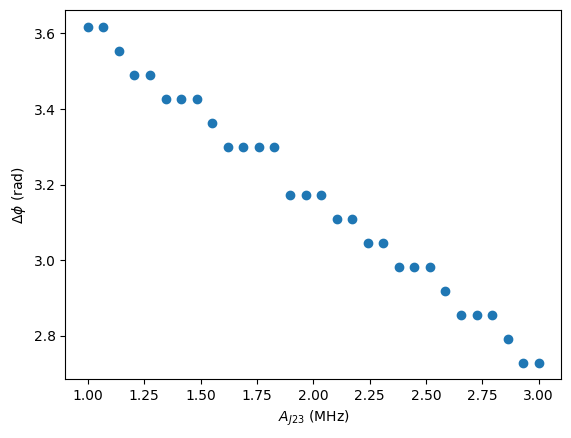

In [20]:
%matplotlib inline
plt.figure()
plt.scatter(J23_scan_rng*1e3, delta_phi_lst)
plt.xlabel(r"$A_{J23}$ (MHz)")
plt.ylabel(r"$\Delta \phi$ (rad)")
# plt.legend()
# plt.title(f"tcz={tcz} ns,Jcz={J23_bias} MHz")
plt.show()
# horizontal_shift

# Miscellary

## PLot the Bloch sphere


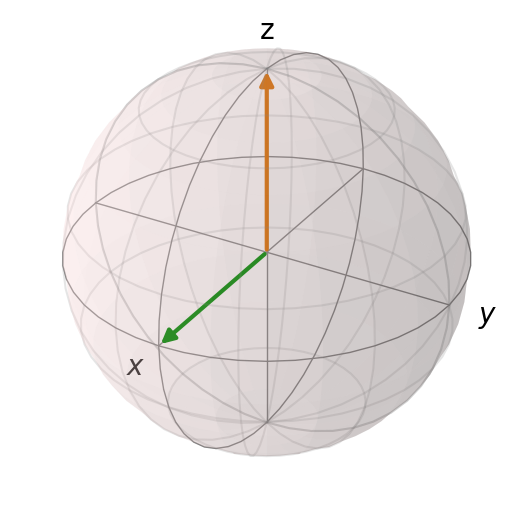

In [4]:
b = Bloch()
b.zlabel = ['z', '']
b.add_vectors([1,0,0])
b.add_vectors([0,0,1])
b.show()